# Final Project: License Plate Reader


Manual license plate reading is prone to errors, especially when there are multiple vehicles, or the plates are dirty, obstructed or damaged. Automated license plate reading (ALPR) using computer vision can improve accuracy, speed up the process, and reduce human error. By using methodologies that we used in class such as image processing/transformation applications and feature matching, we should be able to have our code correctly identify the edges and boundaries of each character to successfully read a license plate.

In order to achieve this, we will be going through the following process:
- Be able to identify the placement of the license plate.
- Identify each character on the license plate.
- Classify each character and add up to get the full number.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import accuracy_score
import pytesseract


## Identifying the License Plate

In order to find the license plate, we first preprocess the image to improve the accuracy of license plate detection and character segmentation, which we achieve through resizing, smoothing, thresholding, and edge detection.

Afterwards, we use computer vision strategies to locate the license plate in the image. 
In our case we make use of contour detection to identify the contour bounding box that contains our license plate.

In [ ]:
# Specify the directory containing the images
plates_dir = 'plates'

# Initialize an empty list to store the results
results = []

# Loop over all files in the directory
for filename in os.listdir(plates_dir):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        # Get the ground truth from the filename
        ground_truth = os.path.splitext(filename)[0]
        
        # Load the image
        img = cv2.imread(os.path.join(plates_dir, filename))

        # Resize the image to a fixed width while maintaining the aspect ratio
        img_width = 600
        aspect_ratio = img.shape[1] / img.shape[0]
        img_height = int(img_width / aspect_ratio)
        img = cv2.resize(img, (img_width, img_height))

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise and smooth the image
        kernel_size = (5, 5)
        blur = cv2.GaussianBlur(gray, kernel_size, 0)

        # Apply adaptive thresholding to separate the foreground (license plate) from the background
        max_value = 255
        block_size = 19
        constant = 9
        th = cv2.adaptiveThreshold(blur, max_value, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, constant)

        # Apply edge detection to highlight the edges of the license plate
        canny = cv2.Canny(th, 30, 150)

        # Display the image with the license plate region highlighted
        cv2.imshow('License Plate Detection', canny)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # Find contours in the image
        contours, hierarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        min_area = 10000
        max_area = 15000

        # Iterate over each contour to find the license plate
        full_img = img.copy()  # Keep a copy of the full image
        plate = None  # Initialize the plate variable
        
        for contour in contours:
            # Get the bounding rectangle of the contour
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / h

            # Check if the aspect ratio of the bounding rectangle is within a certain range to filter out non-license plate regions
            min_aspect_ratio = 2
            max_aspect_ratio = 3
            if aspect_ratio >= min_aspect_ratio and aspect_ratio <= max_aspect_ratio and w*h >= min_area and w*h <= max_area :
                # Draw a rectangle around the license plate region
                x -= 10
                y -= 10
                w += 20
                h += 20
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # Crop the license plate region from the image using the bounding rectangle coordinates
                plate = img[y:y+h, x:x+w]

        # If no license plate was found, use the full image
        if plate is None:
            plate = full_img

        # Display the cropped license plate image
        cv2.imshow('License Plate', plate)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        #Display the image with the license plate region highlighted
        cv2.imshow('License Plate Detection', img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


        plt.figure(dpi=200)
        plt.subplot(1, 3, 1)
        plt.imshow(canny)
        plt.subplot(1, 3, 2)
        plt.imshow(img)
        plt.subplot(1, 3, 3)
        plt.imshow(plate)


       
        predicted_plate = pytesseract.image_to_string(plate, lang ='eng',
                            config='--psm 7 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
        
        # Calculate the accuracy
        min_length = min(len(ground_truth), len(predicted_plate))
        accuracy = np.mean([ground_truth[i] == predicted_plate[i] for i in range(min_length)])*100

        # Append the results to the list
        results.append([ground_truth, predicted_plate, accuracy])
        print(ground_truth, "|", predicted_plate, accuracy)

        
   
# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Ground Truth', 'Predicted Plate', 'Accuracy'])

# Display the DataFrame
print(df)

# Calculate and print the overall accuracy
overall_accuracy = df['Accuracy'].mean()
print('Overall Accuracy: %.2f%%' % overall_accuracy)


05SSR | SS
 0.0
124ZOOM | 4 7
 0.0
174TFS |  nan
191GGQ | 1
 50.0
1962MGA |  nan
B58BPS | B58BPS
 100.0
BB01BB1 |  nan
BLKRCKT | 4
 0.0
CHIOOSE |  nan
DARTV8DR |  nan
DW367BX | NIDEGENY
 0.0
GDDAYM8 | OATH
 0.0
HEMI707 | A EMI
 0.0
KBV4061 | S
 0.0
MPEROR |  nan


## Performing Character Segmentation

Once we have located the license plate region, we can now try to read the characters in the license plate. 
There are two ways to do this, we can either attempt this manually, using similar techniques as in the previous section such as thresholding, contour detection, and bounding box extraction.

Or we can use an optical object recognition package such as pytesseract or easyocr.


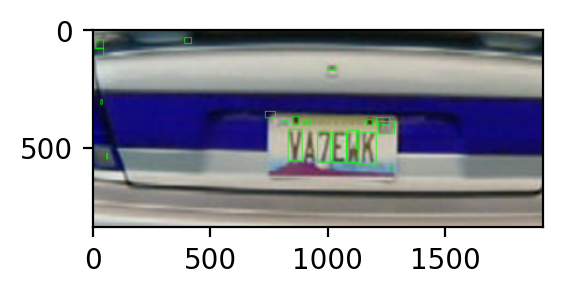

In [14]:
# Apply adaptive thresholding to binarize the image
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Apply dilation to the thresholded image
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=1)

# Find contours in the thresholded image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define a function to sort contours from left to right
def sort_contours(contours):
    # Get the bounding box coordinates for each contour
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    
    # Sort the bounding boxes from left to right based on their x-coordinates
    contours_sorted = [c for _, c in sorted(zip(bounding_boxes, contours), key=lambda b: b[0])]
    
    return contours_sorted

# Sort the contours from left to right
contours = sort_contours(contours)

# Define the minimum and maximum width and height of a character in the license plate
min_char_width = 5
max_char_width = 185
min_char_height = 20
max_char_height = 185

# Iterate over each contour to perform character segmentation
for contour in contours:
    # Get the bounding box coordinates for the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Check if the bounding box is within the minimum and maximum width and height of a character in the license plate
    if w >= min_char_width and w <= max_char_width and h >= min_char_height and h <= max_char_height:
        # Draw a rectangle around the character
        cv2.rectangle(plate, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
# Display the image with the character segments highlighted
cv2.imshow('Character Segmentation', plate)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(dpi=200)
plt.subplot(121)
plt.imshow(plate)

In [15]:
# Import pytesseract
import pytesseract

# Specify the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\ealex\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

# For each detected contour
for contour in contours:
    # Get the bounding box coordinates for the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Check if the bounding box is within the minimum and maximum width and height of a character in the license plate
    if w >= min_char_width and w <= max_char_width and h >= min_char_height and h <= max_char_height:
        # Crop the character from the thresholded license plate
        char = thresh[y:y+h, x:x+w]
        
        # Apply OCR on the cropped image to extract the text
        text = pytesseract.image_to_string(char, config='--psm 10 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
        
        # Write the extracted text into a file
        with open('recognized.txt', 'a') as file:
            file.write(text + ' ')

# Add a newline character at the end of the license plate
with open('recognized.txt', 'a') as file:
    file.write('\n')


In [23]:
##Segmentation Findings

##We were able to get our code to read detect and classify individual characters, as well as ignore anomolies, but we found
##that we got fairly poor results when feeding tesseract by character, so we decided to back-track and see if it would perform
##better on our detected license plate.


In [24]:

# Resize the image to ensure the text is at least 20 pixels high
h, w = gray.shape
if h < 20:
    scaling_factor = 20 / h
    plate_gray = cv2.resize(plate_gray, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

# Apply Gaussian blur to reduce noise
plate_blur = cv2.GaussianBlur(plate_gray, (5, 5), 0)

# Apply thresholding to binarize the image
_, thresh = cv2.threshold(plate_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply OCR on the thresholded license plate
text = pytesseract.image_to_string(thresh, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

# Open the output file in append mode and write the recognized text
with open('recognized3.txt', 'a') as file:
    file.write(text + '\n')